#FACE TRACKER PENGENALAN WAJAH UNTUK PRESENSI MENGGUNAKAN METODE DEEP LEARNING CONVOLUTIONAL NEURAL NETWORK (CNN)
**Muhammad Irfan Setiawan A11.2022.14681**

Ringkasan

Project ini bertujuan untuk menyelidiki, mengembangkan, dan mengembangkan sistem
presensi otomatis yang menggunakan face tracker dan pengenalan wajah untuk meningkatkan
akurasi, efisiensi, dan keamanan absen karyawan/siswa. Hasil project ini diharapkan dapat
berhasil dan bisa diimplementasikan pada organisasi tertentu seperti kantor, pabrik, dan
sekolahan

Ringkasan

Project ini bertujuan untuk menyelidiki, mengembangkan, dan mengembangkan sistem
presensi otomatis yang menggunakan face tracker dan pengenalan wajah untuk meningkatkan
akurasi, efisiensi, dan keamanan absen karyawan/siswa. Hasil project ini diharapkan dapat
berhasil dan bisa diimplementasikan pada organisasi tertentu seperti kantor, pabrik, dan
sekolahan

Tujuan yang Akan Dicapai

Mengembangkan sistem presensi berbasis pengenalan wajah dengan akurasi tinggi menggunakan CNN.
Mengimplementasikan algoritma deep learning yang mampu beroperasi secara real-time.
Mengintegrasikan sistem dengan database untuk penyimpanan data wajah yang aman.
Menyediakan antarmuka pengguna yang intuitif untuk memudahkan penggunaan sistem.
Mengoptimalkan sistem agar tetap akurat dalam berbagai kondisi pencahayaan dan lingkungan.

Alur Penyelesaian

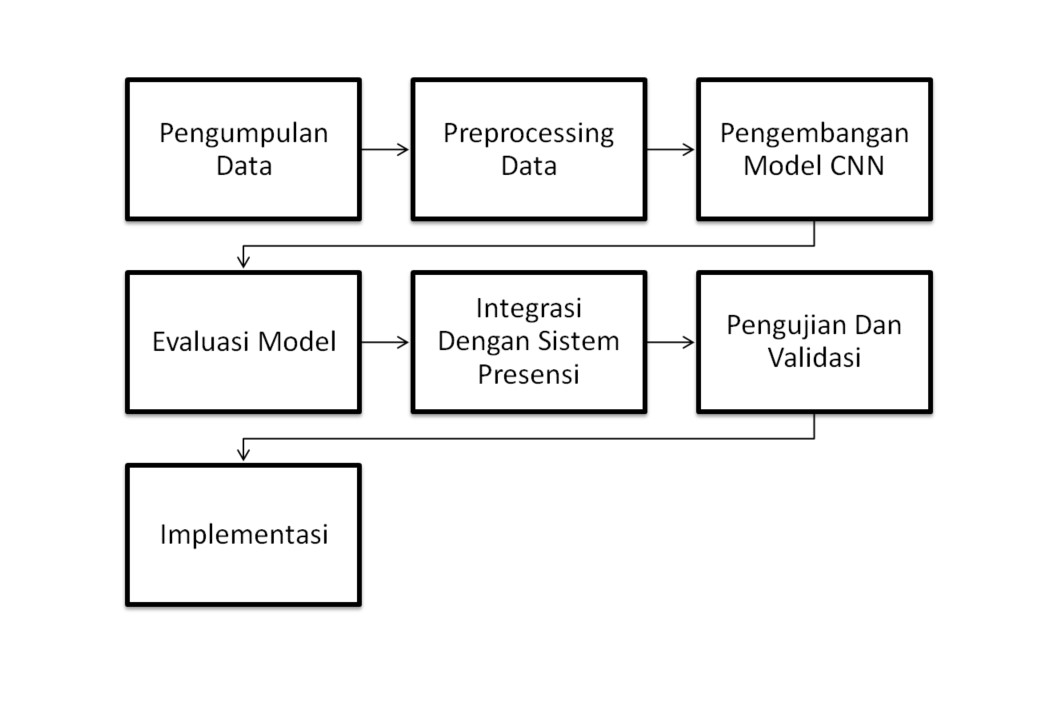

Dataset yang akan digunakan berasal dari kumpulan data publik yang tersedia di
platform Kaggle dengan alamat website yaitu
https://www.kaggle.com/datasets/atulanandjha/lfwpeople serta pengambilan foto wajah langsung dari pengguna Dataset ini bertujuan untuk
mendeteksi pengenalan wajah.

# Proses Modeling (Untuk source code full lengkap saya sertakan link di github)
# Tampilan Homepage

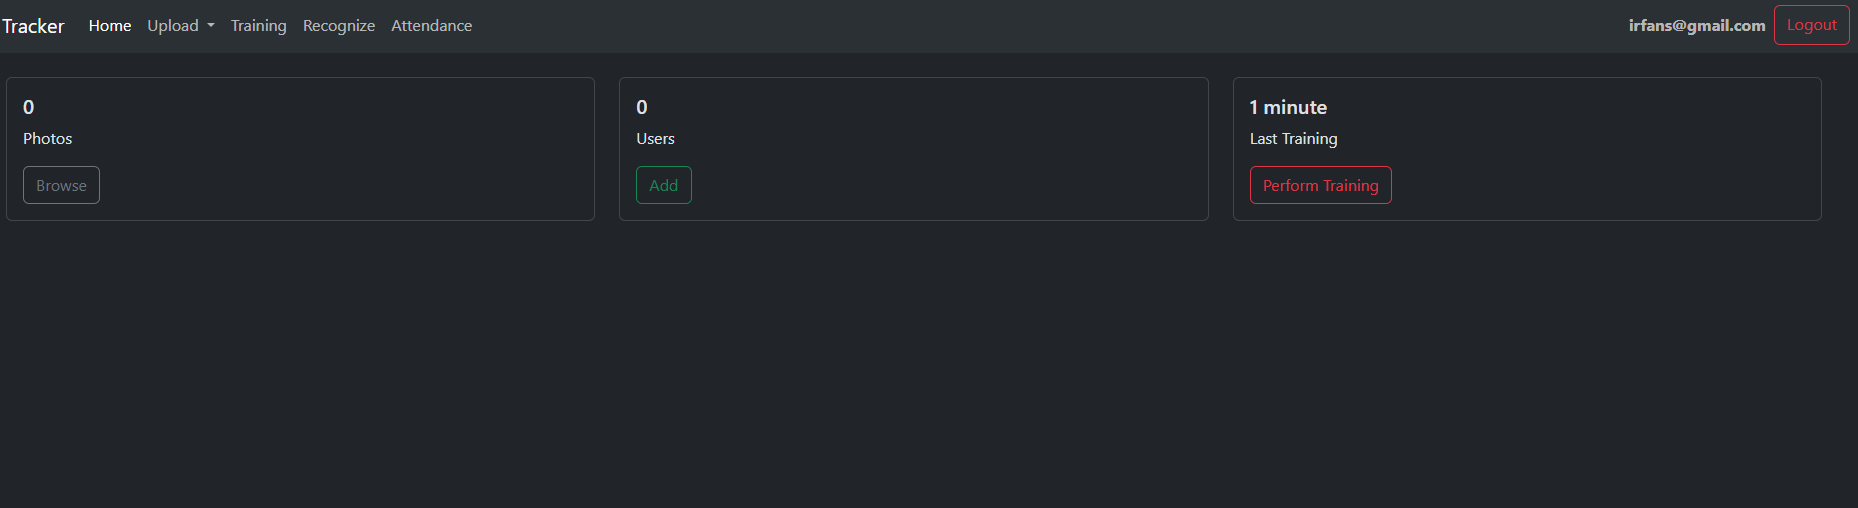

# Preprocessing Data

In [ ]:
# Normalisasi data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Konversi label menjadi one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


# Augmentasi Data

In [ ]:
# Augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)


# Import Libraries

In [ ]:
from base64 import b64decode
from datetime import datetime
from math import ceil
from os import remove
from os.path import isfile, getmtime
from time import time

from django.contrib.auth.decorators import login_required
from django.shortcuts import render, redirect

from tracker import model_filename, temp_path
from tracker.engine import predict, train as do_train
from tracker.forms import UserForm, ImageForm
from tracker.models import Attendance, User, Image


SOURCE CODE

In [ ]:
def home(request):
    return render(request, "home.html", {
        'photos': Image.objects.count(),
        'users': User.objects.count(),
        'last_training': datetime.fromtimestamp(getmtime(model_filename)) if isfile(model_filename) else None
    })



# Tampilan Upload Page
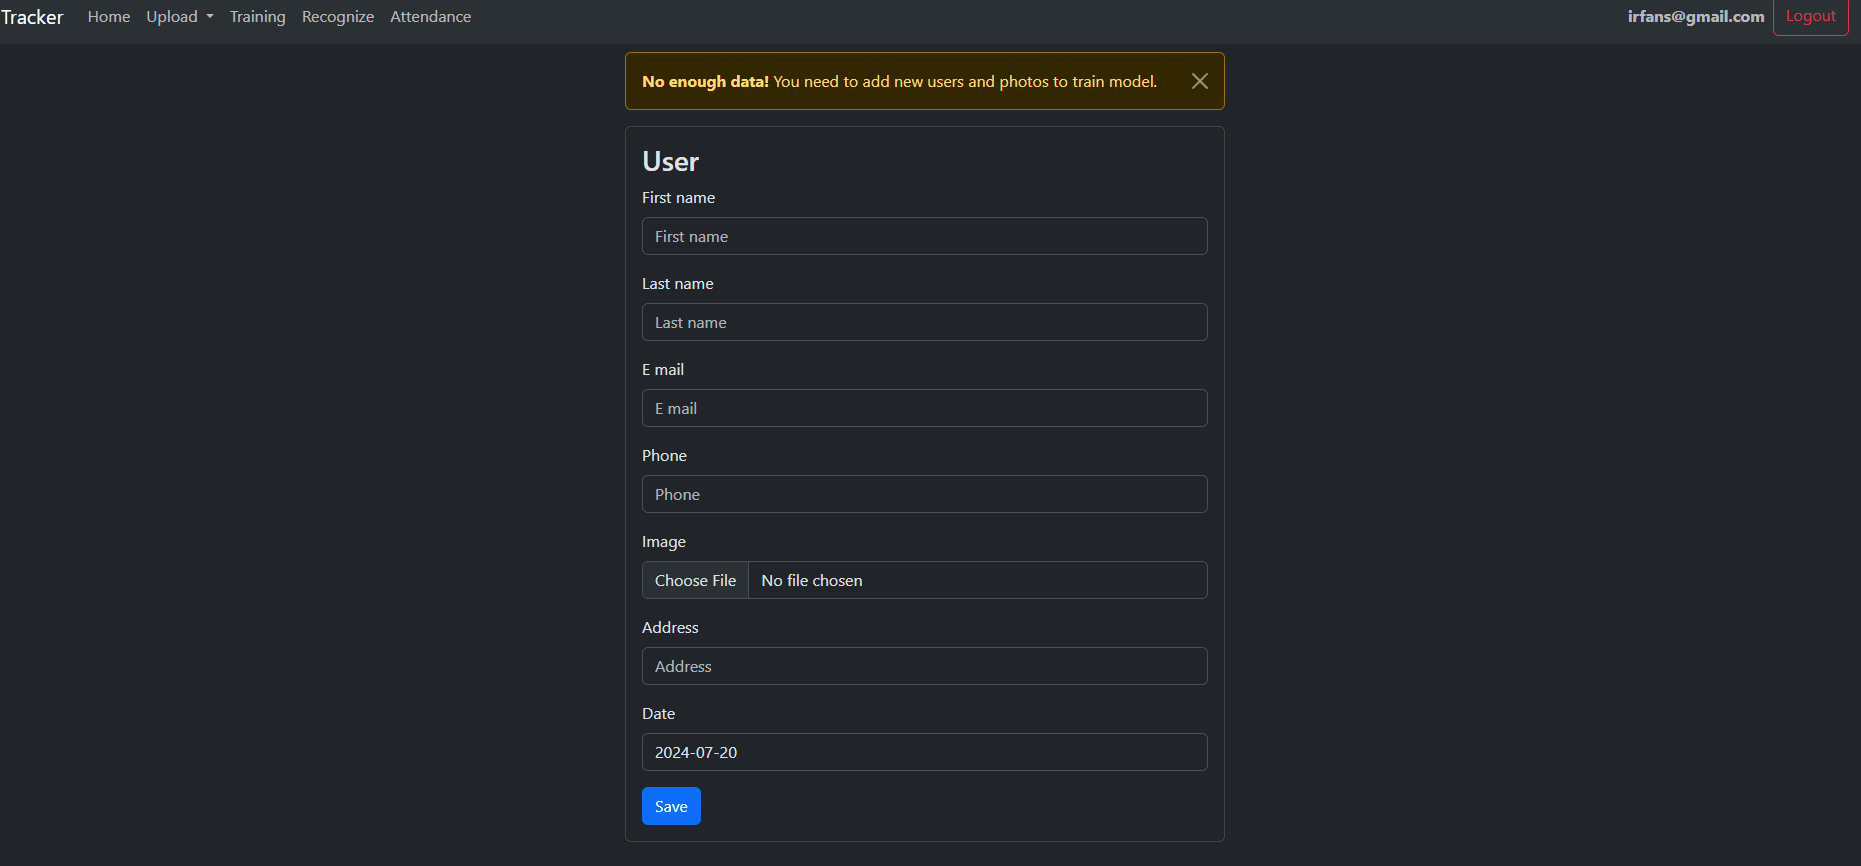

Harus isi data diri terlebih dahulu agar bisa melakukan step berikutnya yaitu login

Source Code

In [ ]:
def add_user(request):
    if request.method == 'POST':
        UserForm(request.POST, request.FILES).save()
        return redirect('users')
    return render(request, 'userdetails.html', {'formset': UserForm()})

# Upload Filled
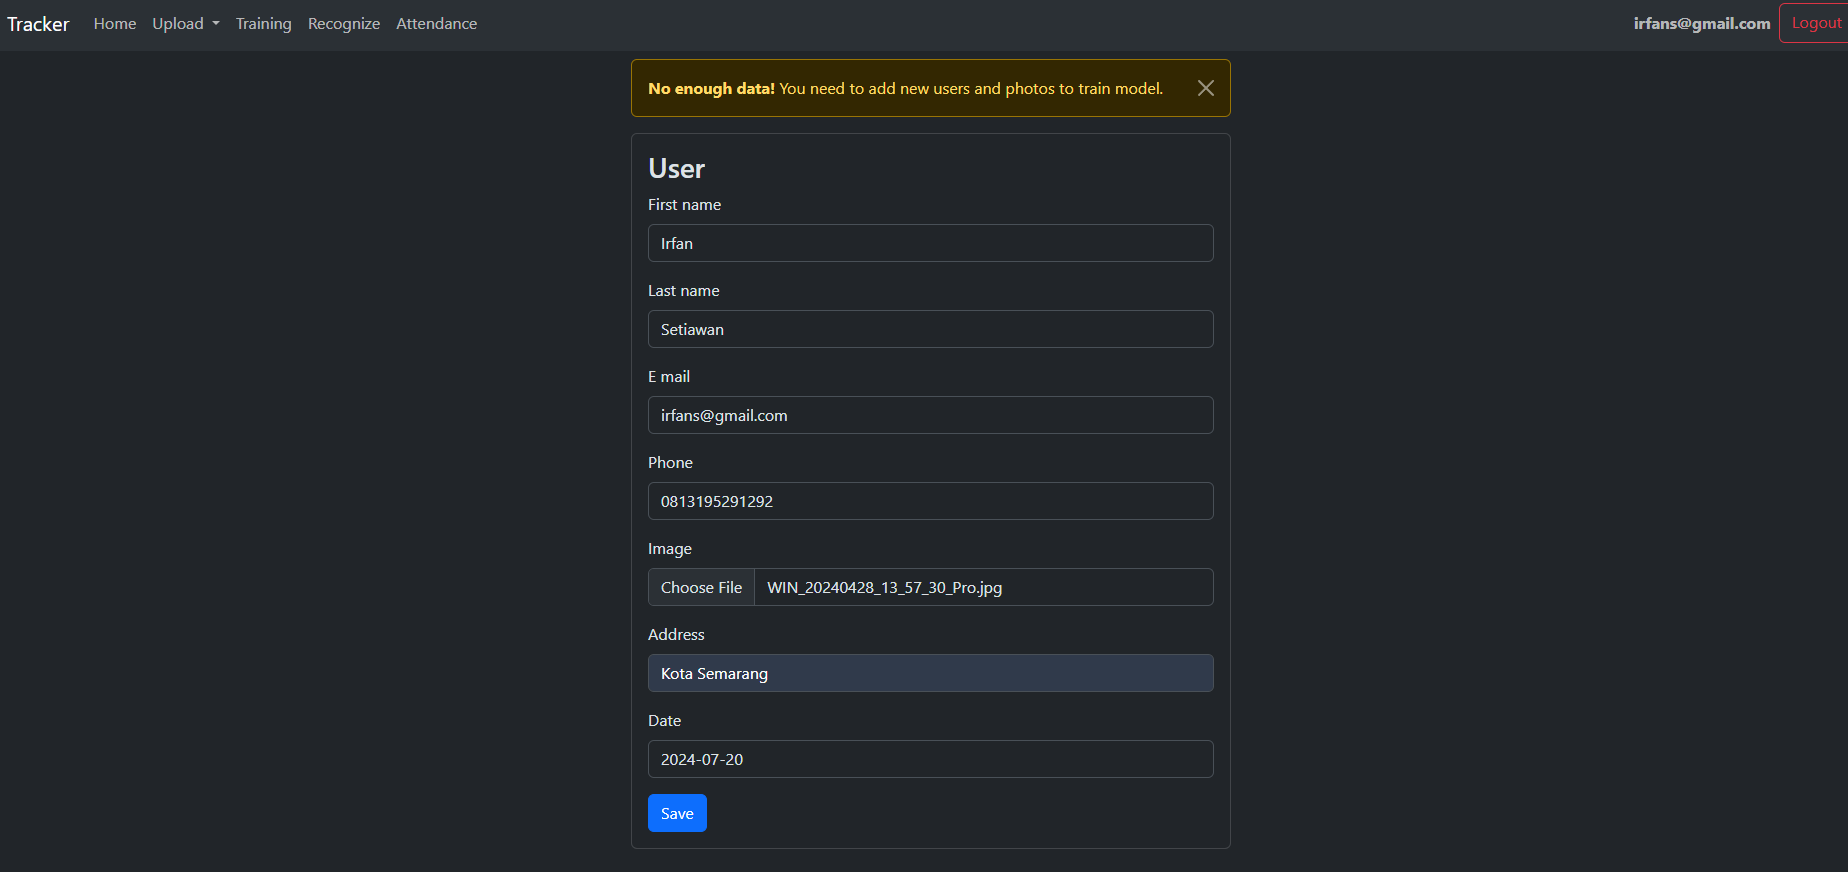

# Upload Success
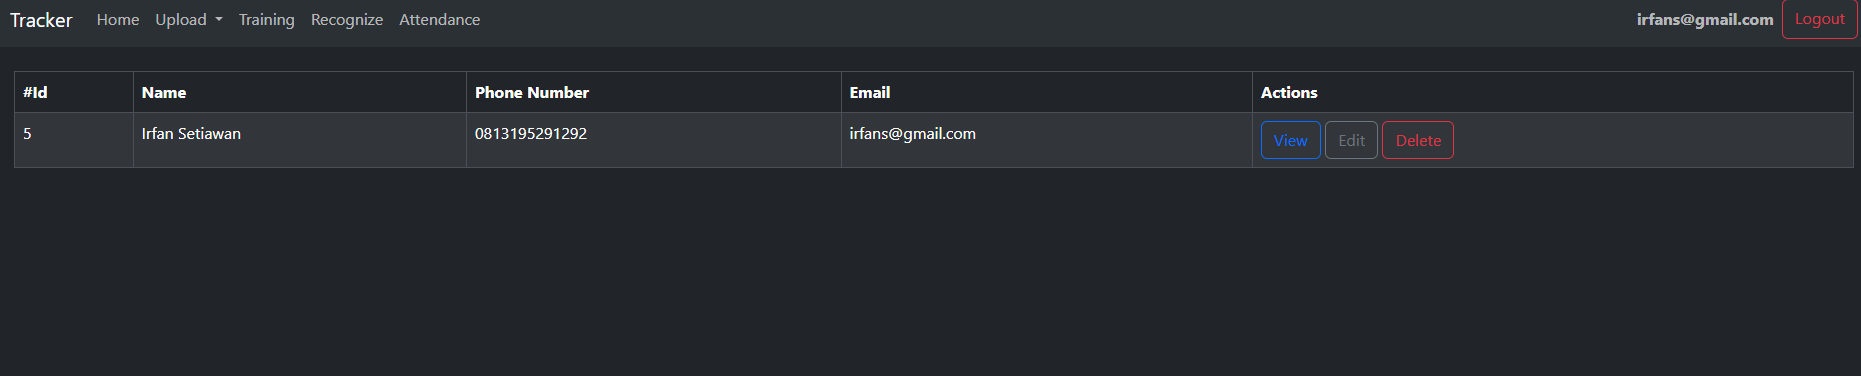

# Pada Foto yang pertama saya gunakan menggunakan foto berikut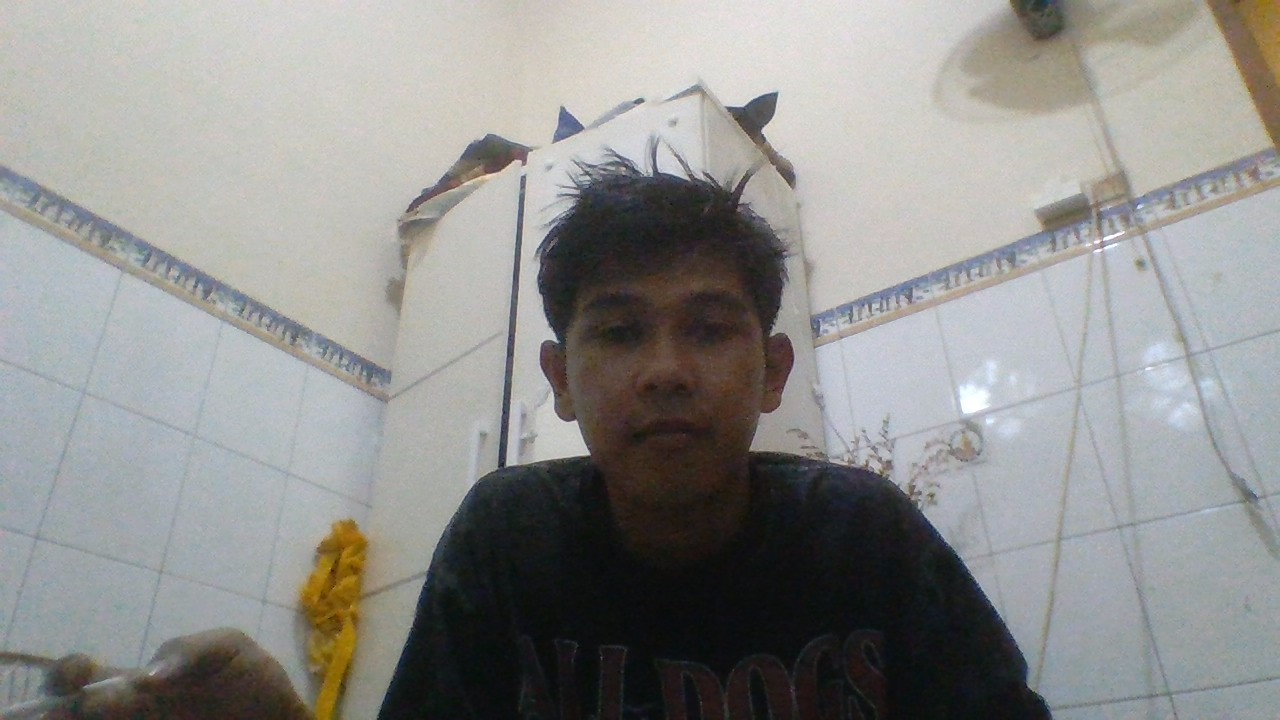

# Upload Capture
Untuk menambahkan foto yang akan di recognize
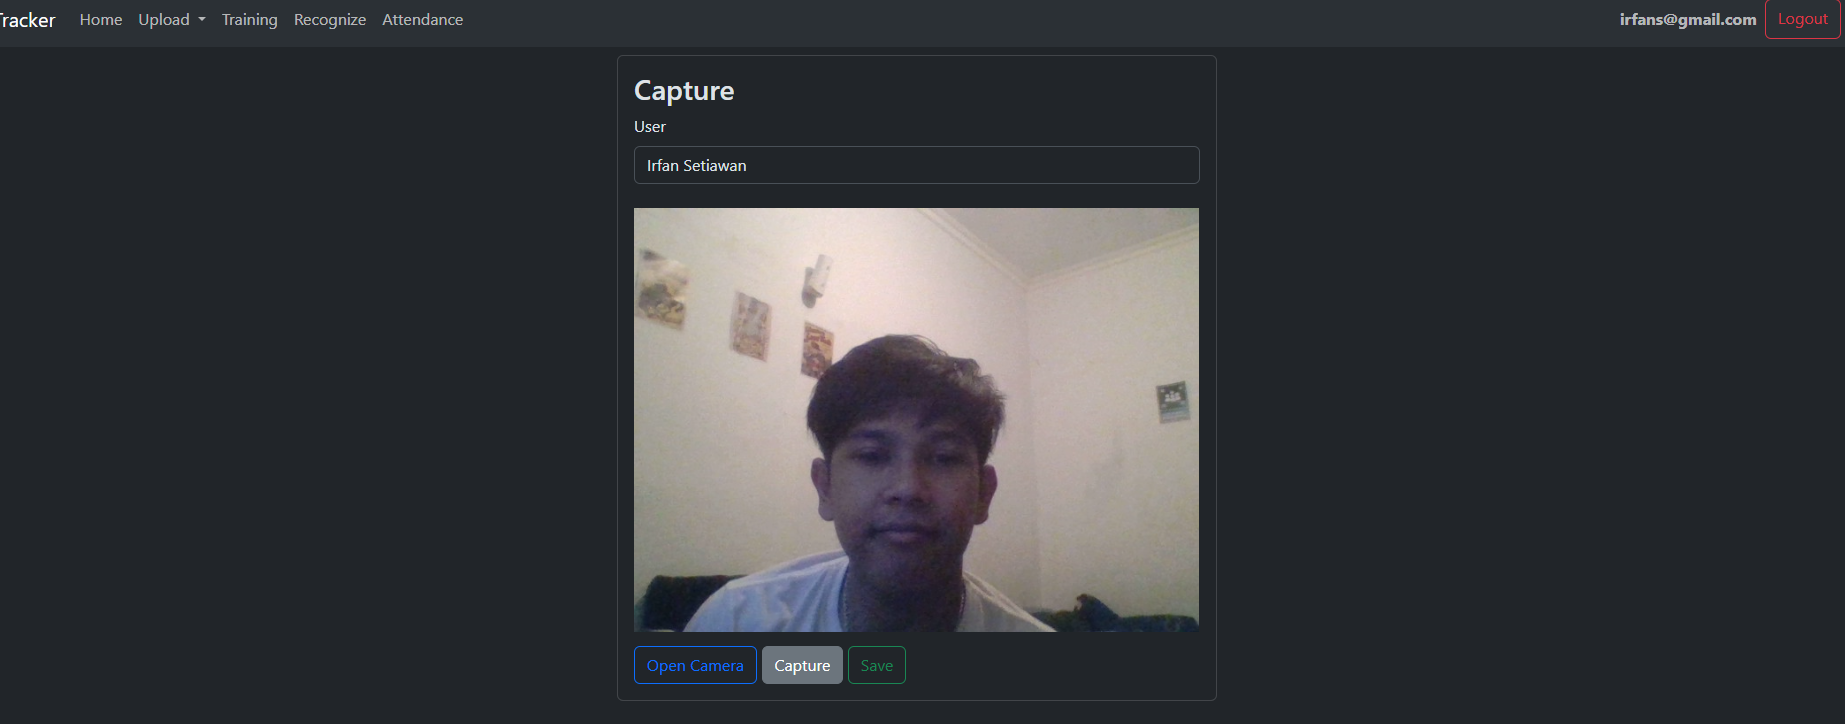

Source Code




In [ ]:
def capture(request):
    if User.objects.count() == 0:
        return redirect('/adduser/?status=empty')
    if request.method == 'POST':
        if frame := request.POST.get('frame'):
            user_id = request.POST.get('user_id')
            ext, img = frame.split(';base64,')
            ext = ext.split('/')[-1]
            filename = f'static/photos/{user_id}_{img[:10]}.{ext}'
            with open(filename, 'wb') as fh:
                fh.write(b64decode(img))
            image = Image(user_id=user_id)
            image.save()
            return redirect('profile', user_id)
    return render(request, 'capture.html', {'users': User.objects.all()})


# Train Page
Page untuk menjalankan model program recognizenya
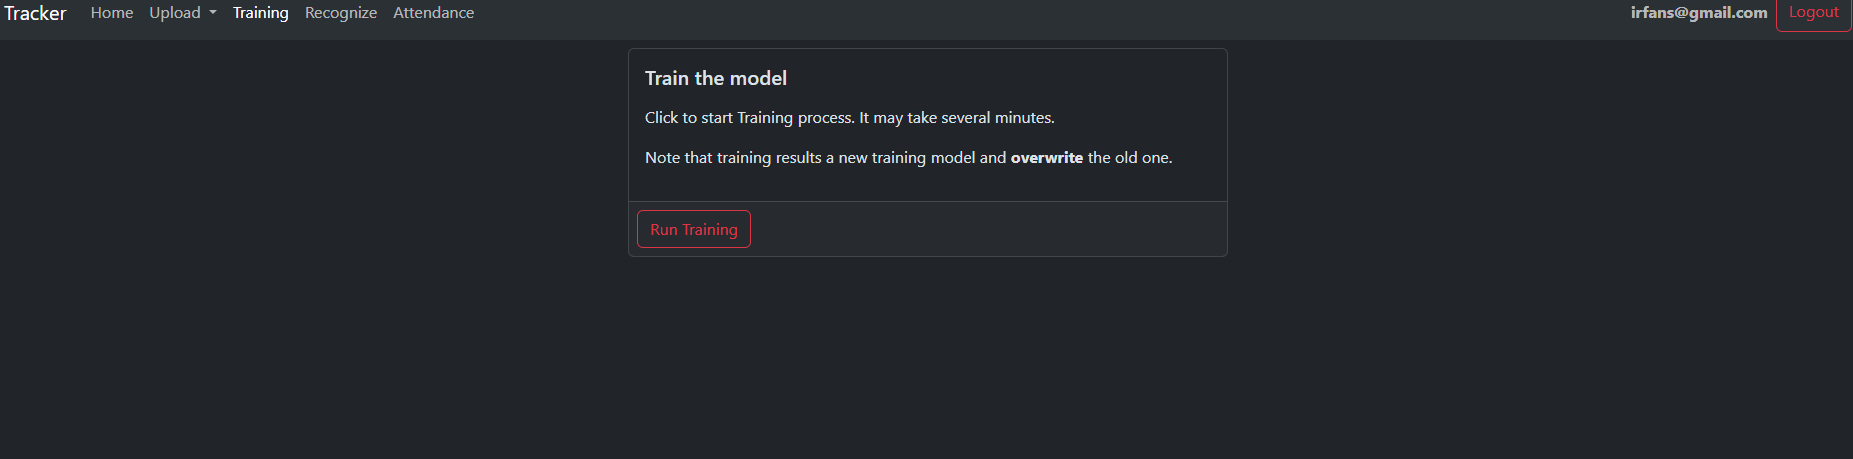


Source Code

In [ ]:
def train(request):
    if not Image.objects.count():
        return redirect('/capture?status=empty')
    if request.method == 'GET':
        return render(request, 'train.html')
    start = time()
    do_train()
    duration = ceil(time() - start)
    return render(request, 'train.html', {'duration': duration})

Train Success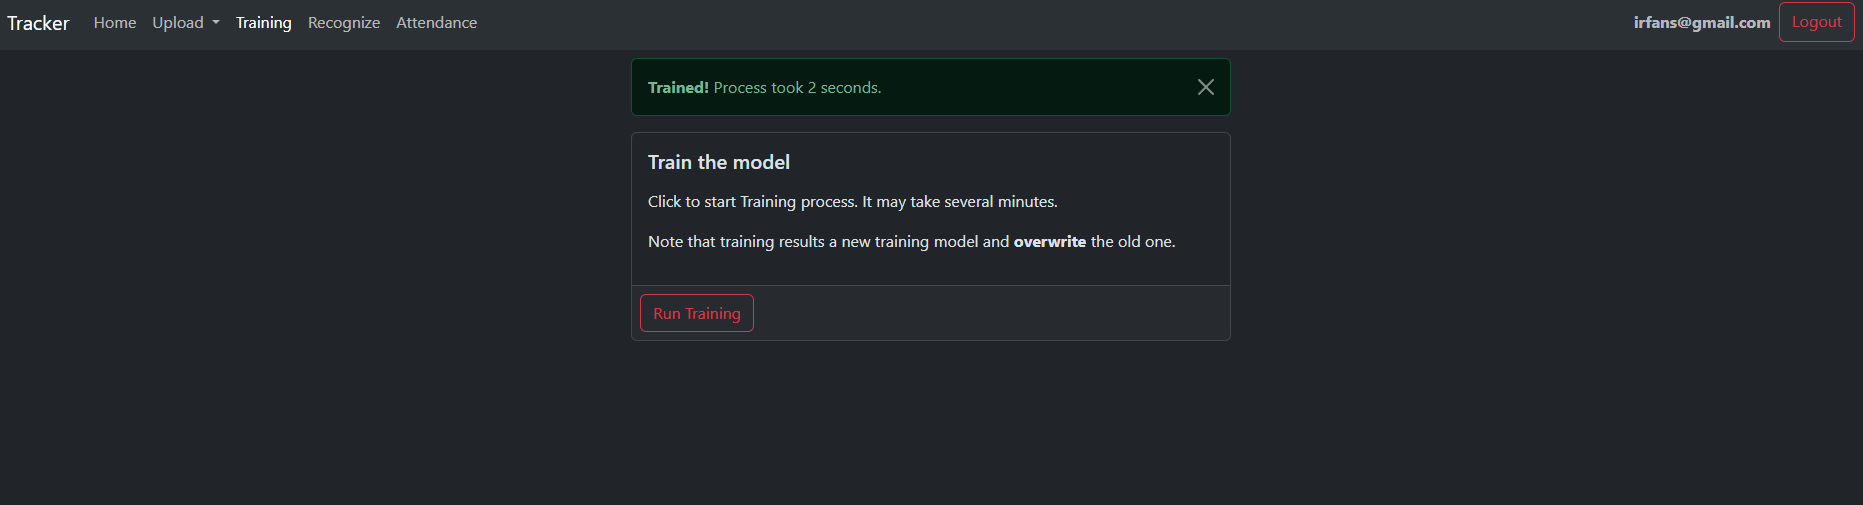

# Recognize Page
Pada Page ini digunakan untuk mencocokan wajah pengguna pada data yang pertama di inputkan dalam page ini kita bisa menambahkan foto bau secara manual ataupun capture foto langsung dari kamera device
 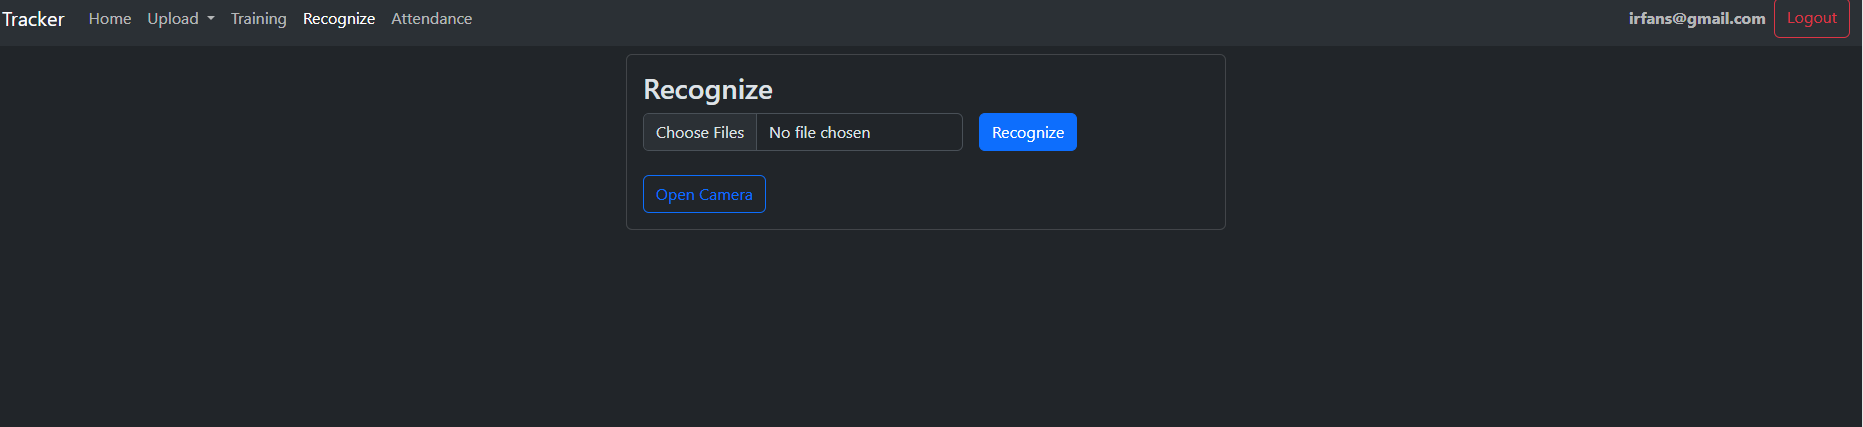

 Page untuk upload ataupun capture

 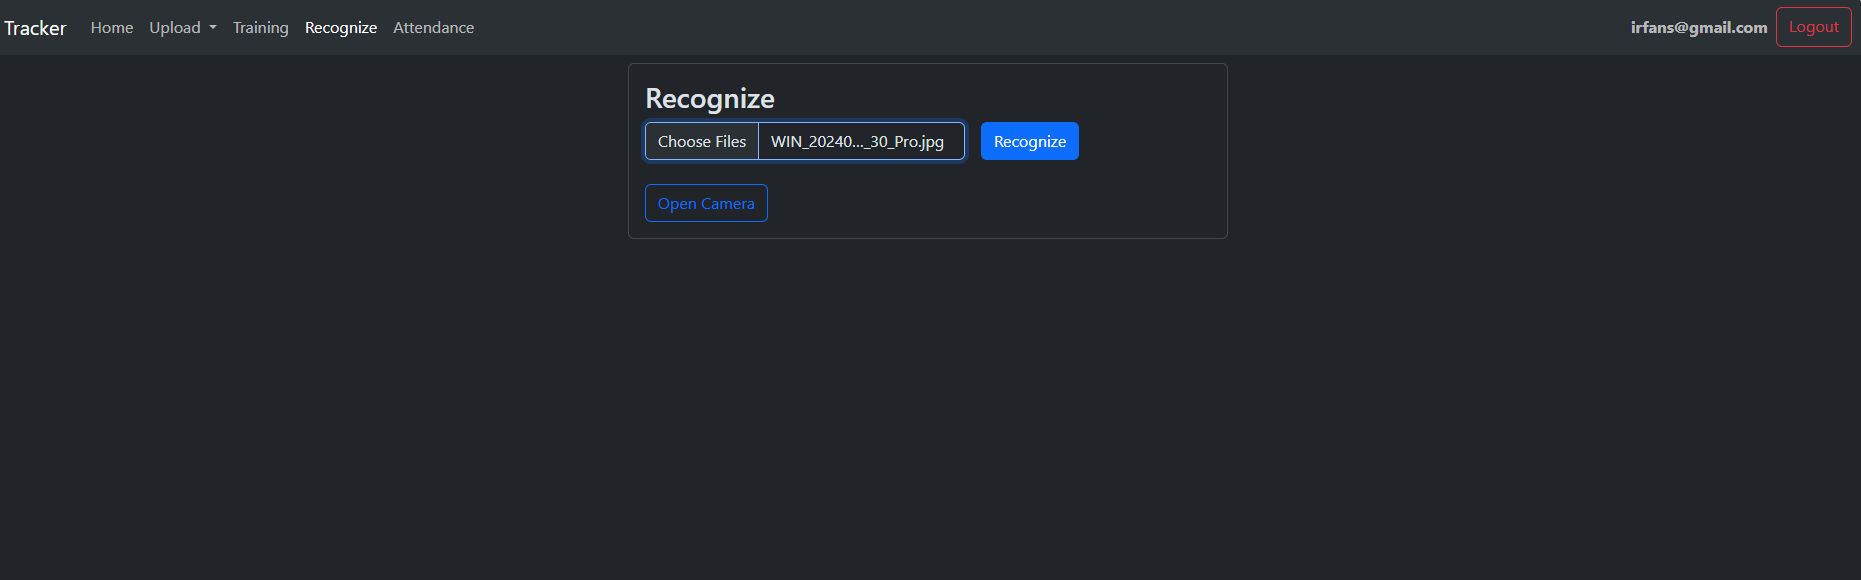


 Page saat recognizenya success
 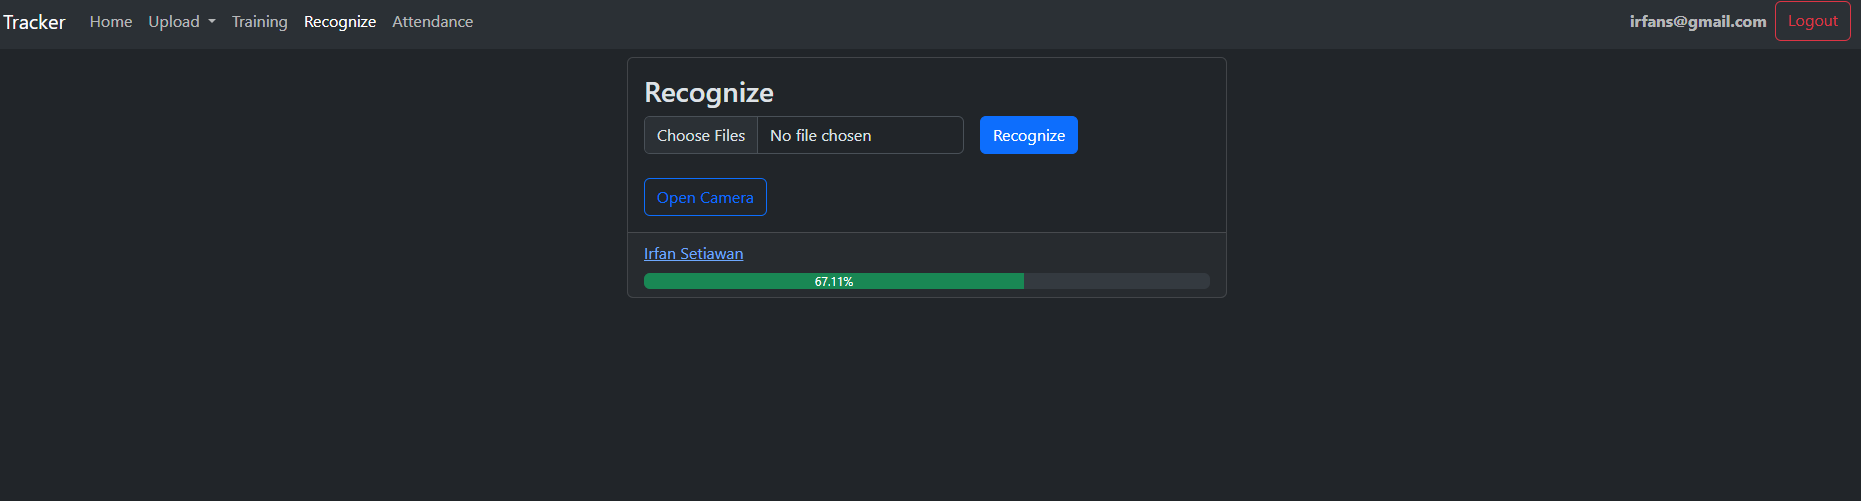

# Source Code Recognize

In [ ]:
def recognize(request):
    if not isfile(model_filename):
        return redirect('/train/?status=untrained')
    if request.method == 'POST':
        files = []
        if frame := request.POST.get('frame'):
            ext, img = frame.split(';base64,')
            ext = ext.split('/')[-1]
            name = f'{temp_path}/rec_frame.{ext}'
            with open(name, 'wb') as fh:
                fh.write(b64decode(img))
            files.append(name)
        if images := request.FILES.getlist('images'):
            for i, image in enumerate(images):
                name = f'{temp_path}/rec{i}.jpg'
                with open(name, 'wb') as fh:
                    fh.write(image.file.read())
                files.append(name)
        if files:
            if predictions := predict(files):
                user_id, confidence = predictions[0][:2]
                user = User.objects.get(id=user_id)
                name = 'Unknown' if user_id in (-1, None) else user.first_name + ' ' + user.last_name
                last_attendance = user.attendance_set.last()
                inout = not last_attendance.inout if last_attendance else True
                if confidence >= 85:
                    Attendance.objects.create(user=user, date=datetime.now(), inout=inout)
                return render(request, 'recognize.html', {'id': user_id, 'name': name, 'confidence': confidence})
            return render(request, 'recognize.html', {'confidence': -1})
    return render(request, 'recognize.html')

Berikut merupakan tampilan homepage setelah foto ditambahkan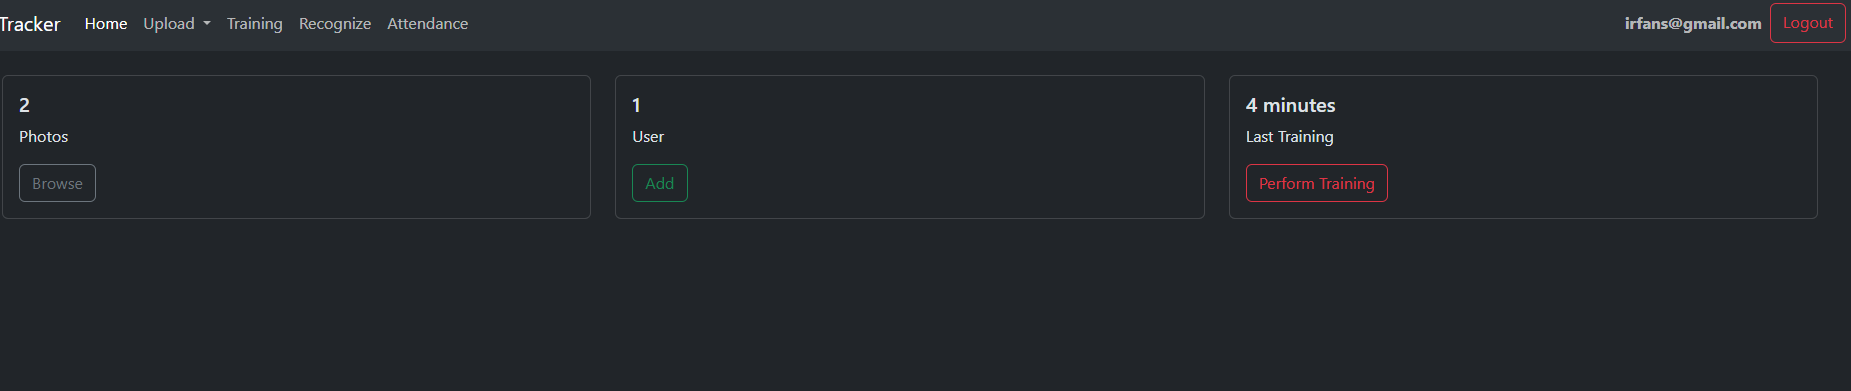

# Diskusi Hasil

*   Model CNN yang dikembangkan menunjukkan akurasi yang baik pada data pengujian.
*   Augmentasi data membantu meningkatkan variasi dalam dataset pelatihan, yang
berkontribusi pada peningkatan akurasi model.
-Preprocessing data seperti normalisasi dan resizing sangat penting untuk kinerja model yang optimal.

# Kesimpulan
*   Sistem presensi berbasis pengenalan wajah menggunakan CNN dapat diimplementasikan dengan sukses
*   Model menunjukkan akurasi yang cukup tinggi 67% dan dapat diandalkan untuk penggunaan real-time namun perlu dikembangkan lagi.
*   Pengembangan lebih lanjut diperlukan untuk mengatasi kondisi pencahayaan yang berbeda dan meningkatkan skalabilitas sistem.



